In [2]:
import numpy as np
import rcca
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import normalize

import torch
import umap

# from mcfa import mcfa_model
# from mcfa import gsea
from scipy import stats
import seaborn as sns
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection
from statsmodels.stats import multitest

In [3]:
ephys = pd.read_pickle("D:/Data For Publication/CCA/ephys_with_labels.p")
ephys = ephys.drop_duplicates('exp_name')
bio = pd.read_pickle("D:/Data For Publication/CCA/biophys_with_labels.pkl")
bio = bio.drop_duplicates('exp_name')
sta = pd.read_pickle("D:/Data For Publication/CCA/sta_with_labels.pkl")
sta = sta.drop_duplicates('exp_name')

In [4]:
ephys_exc  = ephys[~ephys.labels_wave.isin([0,4,5])] 
ephys_inh  = ephys[ephys.labels_wave.isin([0,4,5])] 


bio_exc =  bio[bio.labels_wave==1]
bio_inh =  bio[bio.labels_wave==0]

bio_exc = bio_exc[bio_exc.r_squared_V>0.7]
bio_inh = bio_inh[bio_inh.r_squared_V>0.7]

sta_exc = sta[sta.labels_wave==1]
sta_inh = sta[sta.labels_wave==0]


exc_exps = list(set(sta_exc.exp_name) & set(bio_exc.exp_name) & set(ephys_exc.exp_name))
inh_exps = list(set(sta_inh.exp_name) & set(bio_inh.exp_name) & set(ephys_inh.exp_name))


ephys_exc = ephys_exc[ephys_exc.exp_name.isin(exc_exps)]
ephys_inh = ephys_inh[ephys_inh.exp_name.isin(inh_exps)]


bio_exc = bio_exc[bio_exc.exp_name.isin(exc_exps)]
bio_inh = bio_inh[bio_inh.exp_name.isin(inh_exps)]

sta_exc = sta_exc[sta_exc.exp_name.isin(exc_exps)]
sta_inh = sta_inh[sta_inh.exp_name.isin(inh_exps)]

In [5]:
cols_ephys = ['current_at_first_spike', 'ap_count', 'fr', 'inst_fr',
       'time_to_first_spike', 'mean_isi', 'median_isi', 'max_isi', 'min_isi',
       'first_thr', 'mean_thr', 'median_thr', 'min_thr', 'max_thr',
       'mean_width', 'median_width', 'max_width', 'min_width',
       'mean_amplitude', 'median_amplitude', 'min_amplitude', 'max_amplitude',]
cols_bio = bio_inh.columns[:9]


In [6]:
bio_inh.columns[:9]

Index(['tau_m (ms)', 'R (MOhm)', 'C (nF)', 'gl (nS)', 'El (mV)', 'Tref (ms)',
       'Vr (mV)', 'Vt* (mV)', 'DV (mV)'],
      dtype='object')

In [7]:
cols_bio = ['tau_m (ms)', 'C (nF)', 'gl (nS)', 'El (mV)', 'Vr (mV)', 'Vt* (mV)', 'DV (mV)',]

<Axes: >

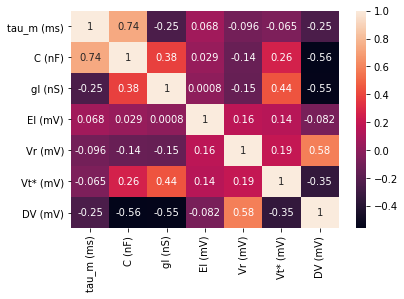

In [8]:
sns.heatmap(bio_inh[cols_bio].corr(),annot=True)

In [9]:
np.vstack(bio_exc['eta'])

array([[-8.76481222e-03, -8.76481222e-03, -8.76481222e-03, ...,
        -2.25826554e-03, -2.25826554e-03, -2.25826554e-03],
       [ 5.47377858e-01,  5.47377858e-01,  5.47377858e-01, ...,
        -2.01031447e-03, -2.01031447e-03, -2.01031447e-03],
       [-1.11786872e-01, -1.11786872e-01, -1.11786872e-01, ...,
         1.66873871e-03,  1.66873871e-03,  1.66873871e-03],
       ...,
       [-2.43363875e-02, -2.43363875e-02, -2.43363875e-02, ...,
        -1.69163423e-05, -1.69163423e-05, -1.69163423e-05],
       [-4.43073045e-02, -4.43073045e-02, -4.43073045e-02, ...,
        -7.29557713e-04, -7.29557713e-04, -7.29557713e-04],
       [ 3.08876322e-01,  3.08876322e-01,  3.08876322e-01, ...,
        -2.59791185e-03, -2.59791185e-03, -2.59791185e-03]])

In [10]:
df_sta_exc = pd.DataFrame(columns=np.arange(2000))
df_sta_exc[df_sta_exc.columns] = normalize(np.vstack(sta_exc['sta'].to_numpy()))
bio_exc[cols_bio] = bio_exc[cols_bio].to_numpy(dtype=np.float32)

df_eta_exc = pd.DataFrame(columns=np.arange(10759))

df_eta_exc[df_eta_exc.columns]  = normalize(np.float32(np.vstack(bio_exc['eta'].to_numpy())))

ephys_exc[cols_ephys] = ephys_exc[cols_ephys].to_numpy(dtype=np.float32)

In [11]:
df_sta_inh = pd.DataFrame(columns=np.arange(2000))
df_sta_inh[df_sta_inh.columns] =normalize(np.vstack(sta_inh['sta'].to_numpy()))
bio_inh[cols_bio] = bio_inh[cols_bio].to_numpy(dtype=np.float32)

df_eta_inh = pd.DataFrame(columns=np.arange(10759))

df_eta_inh[df_eta_inh.columns]  =  normalize(np.float32(np.vstack(bio_inh['eta'].to_numpy())))

ephys_inh[cols_ephys] = ephys_inh[cols_ephys].to_numpy(dtype=np.float32)

In [12]:
ephys[['time_to_first_spike', 'mean_isi', 'median_isi', 'max_isi', 'min_isi']] = ephys[['time_to_first_spike', 'mean_isi', 'median_isi', 'max_isi', 'min_isi']]/1000 

In [15]:
from multicor_fa import mcfa_model

Y_inh = {
    "ephys": ephys_inh[cols_ephys].reset_index(drop='index'), 
    "bio": bio_inh[cols_bio].reset_index(drop='index'), 
    "sta": df_sta_inh,
    'eta':df_eta_inh
    }

Y_exc = {
    "ephys": ephys_exc[cols_ephys].reset_index(drop='index'), 
    "bio": bio_exc[cols_bio].reset_index(drop='index'), 
    "sta": df_sta_exc,
    'eta':df_eta_exc
    }



mcfa_res_inh = mcfa_model.fit(Y_inh,k=[1,1,1,1]) 
mcfa_res_exc = mcfa_model.fit(Y_exc,k=[1,1,1,1])   

Calculating data PCs.


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. 

Calculating exmpirical covariance.
Initialzing model.
Inferring the shared dimensionality.
There are 3 components above rho inclusion threshold 1.5872725248336792.
Fitting the model.
iter: 0 Likelihood: 7336.2548828125
Iter: 1 Likelihood: 7159.4541015625 Percent change: 0.02469472933856989 Time (s): 0.002995729446411133
Iter: 2 Likelihood: 7150.47998046875 Percent change: 0.0012550375804508862 Time (s): 0.006997346878051758
Iter: 3 Likelihood: 7146.91796875 Percent change: 0.0004983982934077244 Time (s): 0.011999368667602539
Iter: 4 Likelihood: 7144.6943359375 Percent change: 0.00031122854358026547 Time (s): 0.018001079559326172
Iter: 5 Likelihood: 7143.04150390625 Percent change: 0.00023139051205934205 Time (s): 0.02299666404724121
Iter: 6 Likelihood: 7141.72998046875 Percent change: 0.00018364226050085385 Time (s): 0.027005434036254883
Iter: 7 Likelihood: 7140.66796875 Percent change: 0.00014872722319504643 Time (s): 0.031999826431274414
Iter: 8 Likelihood: 7139.794921875 Percent cha

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. 

Calculating exmpirical covariance.
Initialzing model.
Inferring the shared dimensionality.
There are 4 components above rho inclusion threshold 1.5087567567825317.
Fitting the model.
iter: 0 Likelihood: 12437.21875
Iter: 1 Likelihood: 12176.2353515625 Percent change: 0.021433833274585125 Time (s): 0.005021810531616211
Iter: 2 Likelihood: 12159.0595703125 Percent change: 0.0014125912576278764 Time (s): 0.00999593734741211
Iter: 3 Likelihood: 12152.125 Percent change: 0.0005706467233097092 Time (s): 0.014992475509643555
Iter: 4 Likelihood: 12148.4873046875 Percent change: 0.00029943607144375855 Time (s): 0.021012306213378906
Iter: 5 Likelihood: 12146.19921875 Percent change: 0.00018837875917331393 Time (s): 0.02599620819091797
Iter: 6 Likelihood: 12144.5654296875 Percent change: 0.00013452840877337512 Time (s): 0.030994892120361328
Iter: 7 Likelihood: 12143.30859375 Percent change: 0.0001035002880637388 Time (s): 0.035996198654174805
Iter: 8 Likelihood: 12142.302734375 Percent change: 8.

In [14]:
mcfa_res_df_inh = pd.concat([mcfa_res_inh.Z] + list(mcfa_res_inh.X.values()), axis=1)
mcfa_res_df_exc = pd.concat([mcfa_res_exc.Z] + list(mcfa_res_exc.X.values()), axis=1)

In [36]:

var_exp_private_exc = {mode: ve_X.sum() for mode, ve_X in mcfa_res_exc.var_exp_X.items()}
var_exp_shared_exc = mcfa_res_exc.var_exp_Z.sum()
var_exp_totals_exc = pd.DataFrame({'Shared': var_exp_shared_exc, 'Specific': var_exp_private_exc})
var_exp_totals_exc['Total'] = var_exp_totals_exc['Shared'] + var_exp_totals_exc['Specific']
var_exp_normed_exc = (mcfa_res_exc.var_exp_Z/var_exp_totals_exc['Total']).T
var_exp_totals_exc['Residual'] = 1 - var_exp_totals_exc['Total']
var_exp_totals_exc = var_exp_totals_exc.drop('Total', axis=1)


var_exp_private_inh = {mode: ve_X.sum() for mode, ve_X in mcfa_res_inh.var_exp_X.items()}
var_exp_shared_inh = mcfa_res_inh.var_exp_Z.sum()
var_exp_totals_inh = pd.DataFrame({'Shared': var_exp_shared_inh, 'Specific': var_exp_private_inh})
var_exp_totals_inh['Total'] = var_exp_totals_inh['Shared'] + var_exp_totals_inh['Specific']
var_exp_normed_inh = (mcfa_res_inh.var_exp_Z/var_exp_totals_inh['Total']).T
var_exp_totals_inh['Residual'] = 1 - var_exp_totals_inh['Total']
var_exp_totals_inh = var_exp_totals_inh.drop('Total', axis=1)

In [37]:

var_exp_totals_exc['dataset'] = var_exp_totals_exc.index
var_exp_totals_exc = var_exp_totals_exc.melt(id_vars=['dataset'], var_name='Space', value_name='Variance explained')



var_exp_totals_inh['dataset'] = var_exp_totals_inh.index
var_exp_totals_inh = var_exp_totals_inh.melt(id_vars=['dataset'], var_name='Space', value_name='Variance explained')

In [38]:
var_exp_totals_exc

,dataset,Space,Variance explained
0,ephys,Shared,0.545269
1,bio,Shared,0.542587
2,sta,Shared,0.316253
3,eta,Shared,0.174668
4,ephys,Specific,0.101413
5,bio,Specific,0.035922
6,sta,Specific,0.563813
7,eta,Specific,0.358673
8,ephys,Residual,0.353318
9,bio,Residual,0.421491


In [39]:
var_exp_totals_inh

,dataset,Space,Variance explained
0,ephys,Shared,0.493047
1,bio,Shared,0.261565
2,sta,Shared,0.053706
3,eta,Shared,0.260124
4,ephys,Specific,0.198086
5,bio,Specific,0.162801
6,sta,Specific,0.816150
7,eta,Specific,0.346419
8,ephys,Residual,0.308867
9,bio,Residual,0.575634


<ipython-input-40-92ed5ba18971>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(yticklabels=['ephys', 'bio','sta','eta'])


[[Text(0, 0, 'ephys'),
  Text(0, 1, 'bio'),
  Text(0, 2, 'sta'),
  Text(0, 3, 'eta')]]

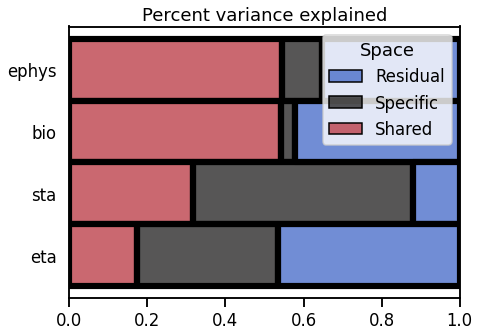

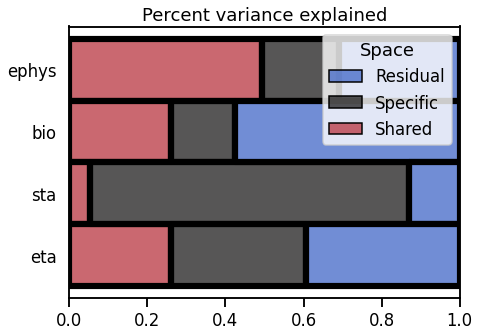

In [40]:
# sns.set_context('talk')
savepath = 'D:/Data For Publication/figures/part2/'
fig,ax = plt.subplots(figsize=(7, 5))
var_exp_totals_exc['Space'] = pd.Categorical(var_exp_totals_exc['Space'], ['Residual', 'Specific', 'Shared'])
sns.histplot(var_exp_totals_exc, y='dataset', hue='Space', weights='Variance explained',
             multiple='stack', palette='icefire',ax =ax)
ax.set(title='Percent variance explained', xlabel=None, ylabel=None)
ax.set_xlim(0, 1)
ax.tick_params(left=False)
ax.set_yticklabels=['ephys','bio','sta','eta']
# plt.savefig(savepath+'alpha_exc.svg',dpi=200)
# plt.show() 

# fig,ax = plt.subplots(figsize=(7, 5))

sns.set_context('talk')
plt.figure(figsize=(7, 5))
var_exp_totals_inh['Space'] = pd.Categorical(var_exp_totals_inh['Space'], ['Residual', 'Specific', 'Shared'])
ax = sns.histplot(var_exp_totals_inh, y='dataset', hue='Space', weights='Variance explained',
             multiple='stack', palette='icefire')
ax.set(title='Percent variance explained', xlabel=None, ylabel=None)
ax.set_xlim(0, 1)
ax.tick_params(left=False)
ax.set(yticklabels=['ephys', 'bio','sta','eta'])
# plt.savefig(savepath+'beta_inh.svg',dpi=100)

# plt.show() 

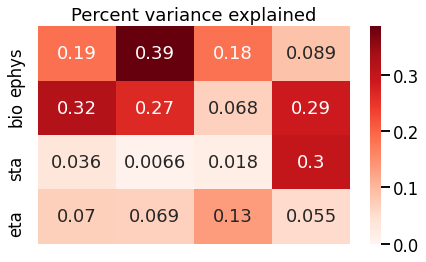

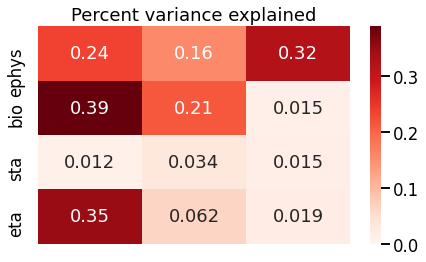

In [49]:

sns.set_context('talk')
plt.figure(figsize=(7, 4))
ax = sns.heatmap(var_exp_normed_exc, vmin=0, cmap='Reds',annot=True)
ax.set(xlabel=None, title='Percent variance explained', xticklabels=[])
ax.tick_params(bottom=False, left=False)
plt.savefig(savepath+'exc_var_per_factor.pdf',dpi=100)
plt.show()


sns.set_context('talk')
plt.figure(figsize=(7, 4))
ax = sns.heatmap(var_exp_normed_inh, vmin=0, cmap='Reds',annot=True)
ax.set(xlabel=None, title='Percent variance explained', xticklabels=[])
ax.tick_params(bottom=False, left=False)
plt.savefig(savepath+'inh_var_per_factor.pdf',dpi=100)

plt.show()

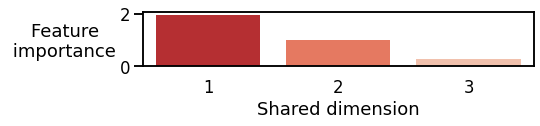

In [50]:
sns.set_context('talk')
plt.figure(figsize=(7, 1))
ax = sns.barplot(x=mcfa_res_inh.rho.index, y=mcfa_res_inh.rho, palette='Reds_r')
ax.set_ylabel('Feature   \n importance', rotation=0, y=0.1, ha='right')
ax.tick_params(bottom=False)
ax.set(xticklabels=range(1, 4))
ax.set(xlabel='Shared dimension')
plt.savefig(savepath+'shared_dim_inh.pdf',dpi=200)
plt.show()

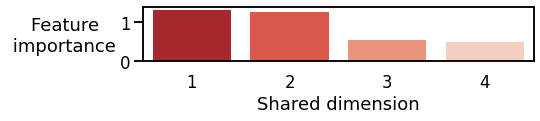

In [51]:
sns.set_context('talk')
plt.figure(figsize=(7, 1))
ax = sns.barplot(x=mcfa_res_exc.rho.index, y=mcfa_res_exc.rho, palette='Reds_r')
ax.set_ylabel('Feature   \n importance', rotation=0, y=0.1, ha='right')
ax.tick_params(bottom=False)
ax.set(xticklabels=range(1, 5))
ax.set(xlabel='Shared dimension')
plt.savefig(savepath+'shared_dim_exc.pdf',dpi=200)
plt.show()

In [61]:

logistic_null = linear_model.LogisticRegression(penalty='none', max_iter=1000, fit_intercept=False)
logistic_fit = linear_model.LogisticRegression(penalty='none', max_iter=1000)
linear = linear_model.LinearRegression()

pred_res = {}
for col in meta_df.columns:
  mask = ~pd.isna(meta_df[col])
  scores = []
  for factor in [mcfa_res.Z] + list(mcfa_res.X.values()):
    if len(pd.unique(meta_df[col])) < 13:
      intercept = np.ones((sum(mask),1))
      null_model = logistic_null.fit(intercept, meta_df[col][mask])
      fit_model = logistic_fit.fit(factor[mask], meta_df[col][mask])
      null_ll = metrics.log_loss(meta_df[col][mask], null_model.predict_proba(intercept), normalize=False)
      fit_ll = metrics.log_loss(meta_df[col][mask], fit_model.predict_proba(factor[mask]), normalize=False)
      r2_score = 1.0 - fit_ll/null_ll
    else:
      fit_model = linear.fit(factor[mask], meta_df[col][mask])
      r2_score = fit_model.score(factor[mask], meta_df[col][mask])
    scores.append(r2_score)
  pred_res[col] = scores
pred_res_1 = pd.DataFrame(pred_res, index=['Z', 'X_exp', 'X_methyl', 'X_protein', ])

NameError: name 'meta_df' is not defined

In [ ]:

embedding_Z = umap.UMAP().fit_transform(Z)
embedding_exp = umap.UMAP().fit_transform(X_ephys)
# embedding_methyl = umap.UMAP().fit_transform(X_methyl)
# embedding_protein = umap.UMAP().fit_transform(X_protein)
# embedding_metab = umap.UMAP().fit_transform(X_metab)

In [ ]:
sns.set_context('talk')
plt.figure(figsize=(7, 7))
ax = sns.scatterplot(data=pd.DataFrame(embedding_Z, columns=['Ax1', 'Ax2'], index=mcfa_res_df.index), x='Ax1', y='Ax2', hue=meta_df['SRA'], style=meta_df['Sex'], palette='colorblind')
ax.set(xlabel='UMAP axis 1', ylabel='UMAP axis 2', title='Shared factors')
ax.set(xticklabels=[], yticklabels=[])
ax.tick_params(bottom=False, left=False)
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0.)
plt.show()